In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
%matplotlib inline

In [3]:
df = pd.read_csv('Reliance_Stock.csv')
df = df.dropna()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-06-08,449.142578,450.727539,437.403839,438.567810,422.947754,5005867.0
1,2015-06-09,437.626740,441.143402,434.555847,437.701019,422.111877,4224271.0
2,2015-06-10,438.840240,450.678009,438.344940,448.647278,432.668274,6234576.0
3,2015-06-11,448.746338,450.479889,432.723206,434.456787,418.983185,6773174.0
4,2015-06-12,435.373108,442.158783,435.001617,440.747162,425.049530,9942471.0


In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1224,2020-06-01,1480.0,1538.349976,1475.949951,1520.349976,1509.805786,18434012.0
1225,2020-06-02,1526.0,1540.000000,1520.800049,1535.699951,1525.049194,10224049.0
1226,2020-06-03,1545.0,1560.000000,1533.349976,1541.650024,1530.958008,11713461.0
1227,2020-06-04,1544.0,1589.500000,1541.000000,1579.800049,1568.843506,15784379.0
1228,2020-06-05,1595.0,1618.000000,1573.699951,1581.699951,1570.730225,15264885.0


In [5]:
df_close = df['Close']

In [6]:
df_close.shape

(1228,)

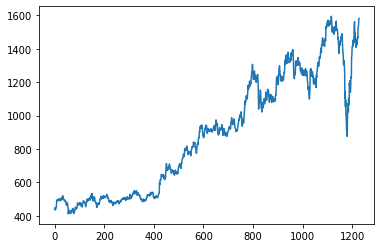

In [7]:
plt.plot(df_close)

In [8]:
scaler = MinMaxScaler(feature_range = (0,1))
df_close = scaler.fit_transform(np.array(df_close).reshape(-1,1))

In [9]:
df_close.shape

(1228, 1)

In [10]:

df_close

array([[0.02338568],
       [0.02265356],
       [0.03189909],
       ...,
       [0.95508044],
       [0.98730304],
       [0.98890775]])

In [11]:
training_size = int(len(df_close) * 0.75)
test_size = len(df_close) - training_size
train_data, test_data = df_close[0:training_size,:], df_close[training_size:len(df_close),:1]

In [12]:
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [13]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [14]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [15]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [17]:

model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
13/13 [==============================] - 12s 398ms/step - loss: 0.0363 - val_loss: 0.0598
Epoch 2/100
13/13 [==============================] - 4s 337ms/step - loss: 0.0065 - val_loss: 0.0123
Epoch 3/100
13/13 [==============================] - 4s 334ms/step - loss: 0.0021 - val_loss: 0.0127
Epoch 4/100
13/13 [==============================] - 4s 337ms/step - loss: 0.0013 - val_loss: 0.0093
Epoch 5/100
13/13 [==============================] - 4s 336ms/step - loss: 0.0010 - val_loss: 0.0090
Epoch 6/100
13/13 [==============================] - 4s 334ms/step - loss: 9.5874e-04 - val_loss: 0.0090
Epoch 7/100
13/13 [==============================] - 4s 336ms/step - loss: 9.5164e-04 - val_loss: 0.0088
Epoch 8/100
13/13 [==============================] - 4s 336ms/step - loss: 9.2316e-04 - val_loss: 0.0087
Epoch 9/100
13/13 [==============================] - 4s 336ms/step - loss: 9.1081e-04 - val_loss: 0.0088
Epoch 10/100
13/13 [==============================] - 4s 335ms/step - loss

In [18]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [19]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [20]:
math.sqrt(mean_squared_error(y_train, train_predict))

812.5305977656169

In [21]:
math.sqrt(mean_squared_error(y_test, test_predict))

1342.5407033197

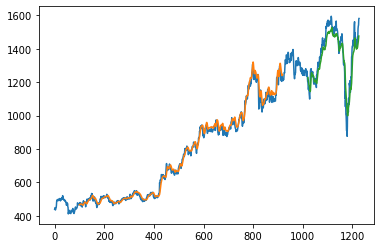

In [22]:
look_back = 100
trainPredictPlot = np.empty_like(df_close)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict


testPredictPlot = np.empty_like(df_close)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2)+1:len(df_close) - 1, :] = test_predict


plt.plot(scaler.inverse_transform(df_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

 Predict the next 30 days Stock Price

In [23]:
len(test_data), x_test.shape


(307, (206, 100, 1))

In [24]:
x_input = test_data[207:].reshape(1,-1)
x_input.shape

(1, 100)

In [25]:

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [26]:
lst_output=[]
n_steps=100
nextNumberOfDays = 30
i=0

while(i<nextNumberOfDays):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.9253133]
101
1 day input [0.94816649 0.94787367 0.94456877 0.93260396 0.92796026 0.93971587
 0.97577755 0.93507227 0.93636911 0.93590896 0.93047043 0.92603592
 0.91348547 0.88436837 0.89114561 0.86094085 0.83408286 0.81220315
 0.84642411 0.8649151  0.87269647 0.85249013 0.85412176 0.86847106
 0.88315514 0.88637642 0.89763003 0.8898069  0.88072869 0.9111845
 0.89624946 0.86194488 0.83805711 0.81764168 0.81283074 0.76463691
 0.75417823 0.776518   0.77388245 0.74999468 0.71640131 0.58516529
 0.61813117 0.54236824 0.57776056 0.50279246 0.4963499  0.4633003
 0.42079611 0.50467503 0.39264122 0.44229924 0.55847464 0.54504564
 0.54454363 0.51513376 0.58483062 0.5569686  0.55445853 0.6620997
 0.6504277  0.67368787 0.64791763 0.61503537 0.63026332 0.67707649
 0.69364315 0.68824648 0.79387949 0.79998737 0.83855912 0.8492271
 0.84788829 0.84688426 0.87955733 0.85378708 0.87508096 0.87516468
 0.91382015 0.95971301 0.97226346 0.89064359 0.91690317 0.86580314
 0.88560974 0.8698574  0.842956   0.86

In [27]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)


In [28]:

df3 = df_close.tolist()
df3.extend(lst_output)

In [29]:
len(df_close)

1228

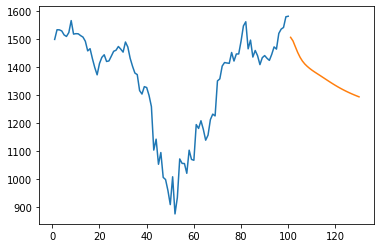

In [30]:

plt.plot(day_new, scaler.inverse_transform(df_close[1128:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))